In [19]:
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
import ujson
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visualizing Epigrass Simulations
Copy this notebook to the `outdata-<yoursim>` directory and adjust variable names accordingly
## Loading the map

In [2]:
mapdf = gpd.read_file('Data.shp')
mapdf['casesp100k'] = 1e5*mapdf.prevalence
mapdf.head()

,NM_MICRO,CD_GEOCMI,prevalence,totalcases,arrivals,population,geometry,casesp100k
0,ADAMANTINA,35035,0.0,0.0,0.0,1.594145e+05,"POLYGON ((-51.32648 -21.29508, -51.32588 -21.2...",0.0
1,AFONSO CLÁUDIO,32007,0.0,0.0,0.0,1.329172e+05,"POLYGON ((-41.15423 -19.75939, -41.15376 -19.7...",0.0
2,AGLOMERAÇÃO URBANA DE SÃO LUÍS,21002,0.0,0.0,0.0,1.338933e+06,"MULTIPOLYGON (((-44.02026 -2.40732, -44.02157 ...",0.0
3,AGRESTE DE ITABAIANA,28004,0.0,0.0,0.0,1.621635e+05,"POLYGON ((-37.34385 -10.54066, -37.34321 -10.5...",0.0
4,AGRESTE DE LAGARTO,28006,0.0,0.0,0.0,1.156281e+05,"POLYGON ((-37.63982 -10.71300, -37.63856 -10.7...",0.0


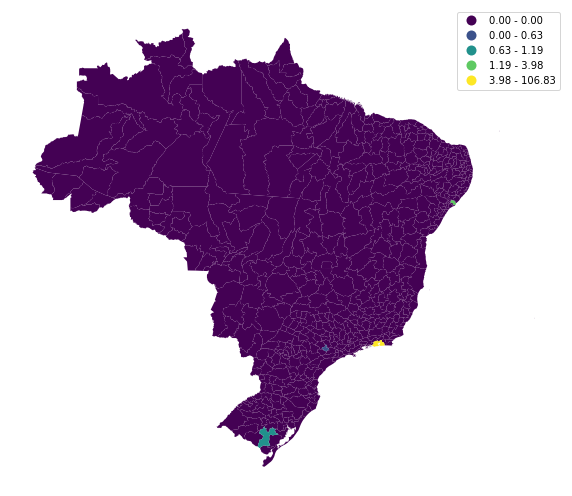

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
mapdf.plot(ax=ax, column='casesp100k', legend=True, scheme='NaturalBreaks');
ax.set_axis_off()

## Loading the Simulated series

In [3]:
from sqlalchemy import create_engine
import os
def get_sims():
    if os.path.exists('Epigrass.sqlite'):
        con = create_engine('sqlite:///Epigrass.sqlite?check_same_thread=False').connect()
        sims = con.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
        return [s[0] for s in sims if not (s[0].endswith('_meta') or s[0].endswith('e'))]
    else:
        return ['No simulations found']

In [4]:
sim_select = widgets.Select(
    options=get_sims(),
#     value='OSX',
    description='Simulations available:',
    disabled=False
)
display(sim_select)

Select(description='Simulations available:', options=('brasil_Sat_Mar_21_151243_2020', 'brasil_Sat_Mar_21_1531…

In [5]:
simulation = sim_select.get_interact_value()
con = create_engine('sqlite:///Epigrass.sqlite?check_same_thread=False').connect()
simdf = pd.read_sql_table(simulation, con)
simdf.fillna(0, inplace=True)
simdf

,geocode,time,name,lat,longit,Exposed,Infectious,Susceptible,incidence,Arrivals
0,35035,0,ADAMANTINA,-51.012231,-21.648638,0.0,0.000000,159414.511689,0.000000,0.0
1,35035,1,ADAMANTINA,-51.012231,-21.648638,0.0,0.000000,159414.511689,0.000000,0.0
2,35035,2,ADAMANTINA,-51.012231,-21.648638,0.0,0.000000,159414.511689,0.000000,0.0
3,35035,3,ADAMANTINA,-51.012231,-21.648638,0.0,0.000000,159414.511689,0.000000,0.0
4,35035,4,ADAMANTINA,-51.012231,-21.648638,0.0,0.000000,159414.511689,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
55795,13005,95,TEFÉ,-64.940706,-3.867544,0.0,69.609717,881.604386,33.138124,10983.0
55796,13005,96,TEFÉ,-64.940706,-3.867544,0.0,66.453258,849.955987,31.648400,10985.0
55797,13005,97,TEFÉ,-64.940706,-3.867544,0.0,63.465463,819.717152,30.238834,10987.0
55798,13005,98,TEFÉ,-64.940706,-3.867544,0.0,60.639744,790.810140,28.907013,10990.0


interactive(children=(Select(description='Cities available:', index=111, options=('ITAPETINGA', 'CARIRI OCIDEN…

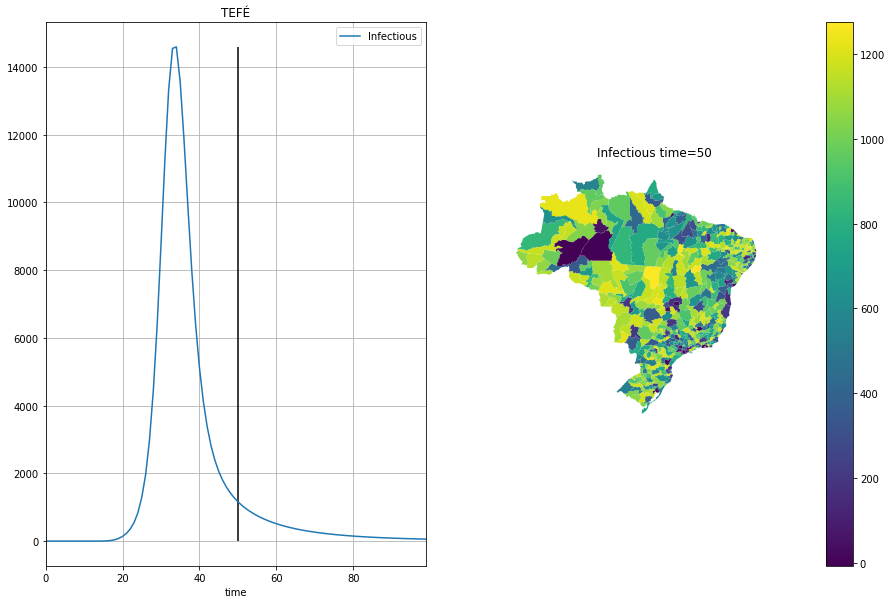

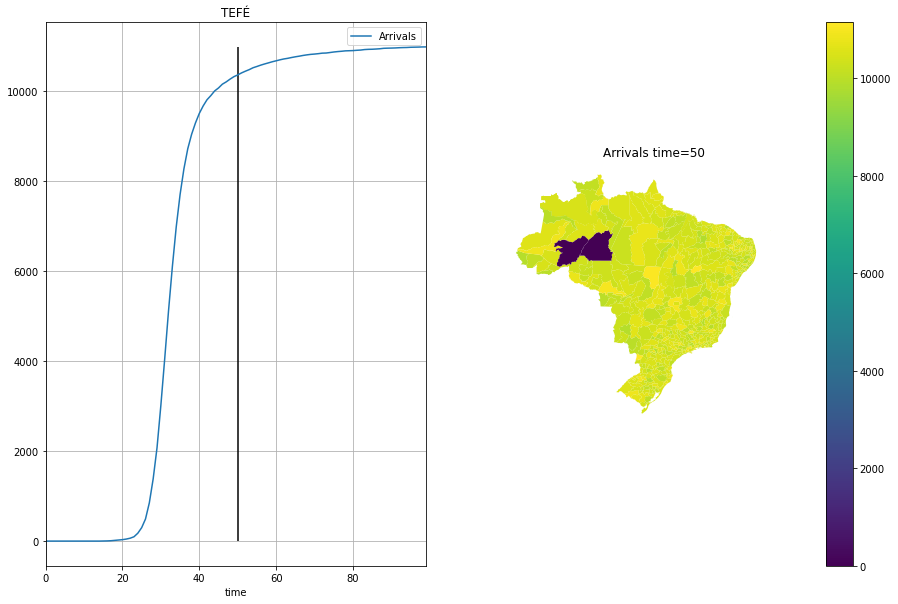

In [18]:
city_select = widgets.Select(
    options=set(simdf.name),
    value='TEFÉ',
    description='Cities available:',
    disabled=False
)
@interact(city=city_select,time=(simdf.time.min(),simdf.time.max(),1),var=['Exposed','Infectious','Susceptible','Incidence','Arrivals'])
def animate(city='TEFÉ', time=50, var='Infectious'):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
#     mapa = mapdf[mapdf.NM_MICRO==city]
    values = simdf[(simdf.name==city)&(simdf.time==time)][var].iloc[0]
    mapa = pd.merge(mapdf, simdf[simdf.time==time][['name', 'time', var]], left_on='NM_MICRO', right_on='name')

    simdf[simdf.name==city].plot(x='time',y=var, ax=ax1)
    ax1.set_title(f'{city}')
    ax1.vlines(time,0,simdf[simdf.name==city][var].max())
    ax1.grid()
    
    mapa.plot(ax=ax2, column=var, legend=True);
    ax2.set_title(f'{var} time={time}')
    ax2.set_axis_off()
    clear_output(wait=True)
    

In [29]:
mapdf[mapdf.NM_MICRO=='TEFÉ']

,NM_MICRO,CD_GEOCMI,prevalence,totalcases,arrivals,population,geometry,casesp100k
561,TEFÉ,13005,0.0,0.0,0.0,87495.675698,"POLYGON ((-65.17575 -2.32562, -65.17272 -2.326...",0.0


In [34]:
simdf[(simdf.name=='TEFÉ')&(simdf.time==0)]['Infectious'].iloc[0]

0.0

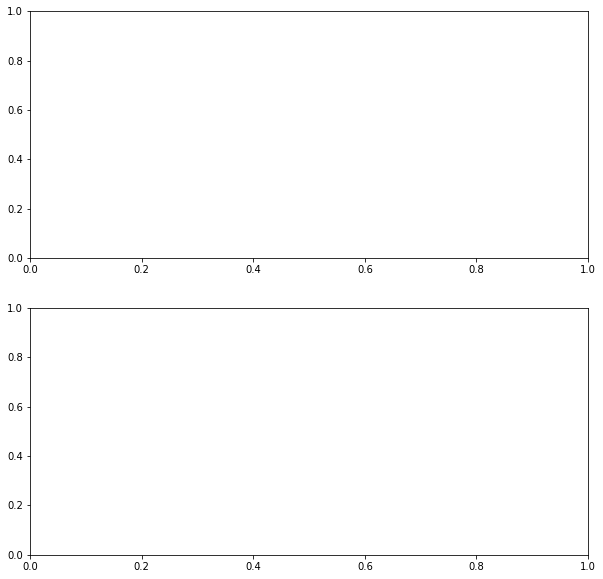

In [48]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1?